In [433]:
#AnalyticalModel  - Purpose: calculate pressures based on Jaz flow videos. do geometric optimization. 
#This one assumes a sputtered or evaporated coating with a fixed coating depth/pore diameter ratio.
#(Much higher pressures can be reached with a fully metal coated pore)
#CKH Dec 10 2016 - No CFD, combines Anderson and Idol 1985 paper with
#the local zeta potential and surface velocity using the method of Wu and Li (2008)
#Wu, Zhemin, and Dongqing Li. "Mixing and flow regulating by induced-charge electrokinetic flow in a microchannel with a pair of conducting triangle hurdles." Microfluidics and nanofluidics 5.1 (2008): 65-76.

In [434]:
#Something about units here
#Maxwell will export units in the column labels. Check below for a list of the column labels.
epsilon =80.0*8.854e-12 #dielectric constant of water in F/m
eta=8.9e-4 #dynamic viscosity of water in Pa*s

#Currently ignores surface velocity on the polymer, because its time average is 0 when 
#driven by a pure AC electric field. 
#Also add the partially coated pore effect - and show what difference it makes.
#But it would be needed if we want to flip the sign of the voltage and show the flow pattern in each half cycle.
zetaPolymer=-0.02#zeta potential of the bare polymer membrane in volts
#It will depend on what the surrounding solution is
#I used -20 mV for polycarbonate at low concentration (pC near 0) and medium pH around 7
#From fig 2b in Electrophoresis (2004) 25, 203–213
#http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.559.3862&rep=rep1&type=pdf

In [435]:
#imports
import numpy as np

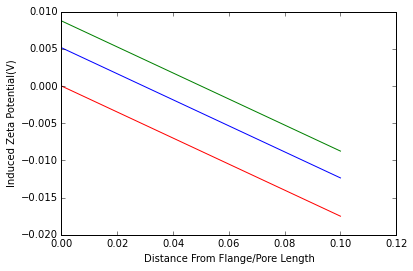

In [436]:
#The Maxwell results and CFD results showed 2 things
#1. The voltage drop is pretty much linear along the pore
#2. The velocity vectors along the top of the membrane are really small and don't contribute much;
#we didn't see any vortices or anything from those

#Use the CFD to produce images and use this analytical model to iterate quickly over different settings
#for the pore width, metal coating depth, membrane thickness and pore separation.

#To get the tangential velocity profile, have to calc the zeta potential along the contour.
#In Wu's paper, the induced zeta potential is Phi-sub-c - Phi-sub-e, where
#Phi-sub-c is the spatial average of the external voltage Phi-sub-e over the metal surface, 
#Phi-sub-e is the external voltage which looks pretty much like transmembrane voltage * z/length

#I made a formula specific to the tube and flange, and made it nondimensionalized in 12/9/16 lab book
Vt=0.175#trans-membrane voltage in volts, starts at 0 at the metal side
lmlp=0.1 #Length of Metal/Length of Pore: Fraction of pore depth coated with metal; we have 0.08 - 1 micron depth out of 10 micron thickness
rplm=0.2 #Radius of Pore/Length of Metal: Aspect ratio of metal tube; cross section showed we have 1 micron deep and 200 nm radius for 0.2
rfrp=2.83 #Radius of Flange/Radius of Pore: This average ratio for pores with 12.5 percent open area is 2.83

def phicalc(Vt,lmlp,rplm,rfrp):
    phic=Vt*lmlp/(rplm*(rfrp**2-1)+2)
    return phic

phic1=phicalc(Vt,lmlp,rplm,rfrp)
phicSinglePore=phicalc(Vt,lmlp,rplm,1000)#bigger flange radius to pore radius, effectively entire tube is one sign
phicTube=phicalc(Vt,lmlp,rplm,1)#symmetric case, equal flange and tube

def zetapot(zl,phic,Vt):
    zeta=phic-Vt*zl
    return zeta

zl=np.linspace(0,lmlp,50) #relative lengths along the pore
%matplotlib inline
from matplotlib import pyplot as plt
plt.plot(zl,zetapot(zl,phic1,Vt))#Your blue line is going to be somewhere between the two lines
plt.hold('true')
plt.plot(zl,zetapot(zl,phicSinglePore,Vt),'r') #Pretty much maxes out at some large flange size, would be interesting to plot
plt.plot(zl,zetapot(zl,phicTube,Vt),'g') #Here the tubes have no space between them. This case should be symmetric
plt.ylabel('Induced Zeta Potential(V)')
plt.xlabel('Distance From Flange/Pore Length')

In [437]:
#Keep in mind the Helmholtz-Smoluchowski expression is hardly valid 
#for voltages > a few dozen mV
plength=10e-6 #pore length in meters
etang=-Vt/plength

AvgZetaPos=lmlp*(zetapot(0,phic1,Vt)+zetapot(lmlp,phic1,Vt))/2 +(1-lmlp)*zetaPolymer #Average zeta potential within the tube when voltage is pos
AvgZetaNeg=lmlp*(zetapot(0,-phic1,-Vt)+zetapot(lmlp,-phic1,-Vt))/2+(1-lmlp)*zetaPolymer #Avg zeta potential within tube when voltage is neg
#Anderson & Idol 1985, says velocity is given by AVERAGE zeta potential in a capillary if it's non-uniform, an amazing result
AvgUcontourPos=-epsilon*AvgZetaPos*etang/eta  #Helmholtz-Smoluchowski slip velocity in meters/s along the direction of the contour
AvgUcontourNeg=epsilon*AvgZetaNeg*etang/eta
TimeAvgVelocity=(AvgUcontourPos+AvgUcontourNeg)/2
AvgZetaPos,AvgZetaNeg,AvgUcontourPos,AvgUcontourNeg,TimeAvgVelocity


(-0.018360563440316544,
 -0.01763943655968346,
 -0.00025571932604582885,
 0.0002456757301339463,
 -5.0217979559412775e-06)

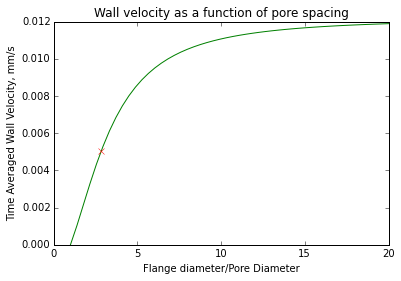

In [438]:
#How does the time-averaged zeta potential and wall velocity depend on flange-to-pore diameter ratio?
rfrps=np.linspace(1,20,50)
phics=[phicalc(Vt,lmlp,rplm,rfrp) for rfrp in rfrps]

avgZPos=np.array([lmlp*(zetapot(0,phic,Vt)+zetapot(lmlp,phic,Vt))/2+(1-lmlp)*zetaPolymer for phic in phics])
avgZNeg=np.array([lmlp*(zetapot(0,-phic,-Vt)+zetapot(lmlp,-phic,-Vt))/2+(1-lmlp)*zetaPolymer for phic in phics])

avgUPos=-epsilon*avgZPos*etang/eta
avgUNeg=epsilon*avgZNeg*etang/eta

def avgUPositive (Vto,lmlpo,rplmo,rfrpo,zetaPolymer,plength):#calculate a single avgUPositive for a set of variables
    etango=-Vto/plength
    phico=phicalc(Vto,lmlpo,rplmo,rfrpo)
    avgZPoso=lmlpo*(zetapot(0,phico,Vto)+zetapot(lmlpo,phico,Vto))/2+(1-lmlpo)*zetaPolymer
    avgUPoso=-epsilon*avgZPoso*etango/eta
    return avgUPoso

def avgUNegative(Vto,lmlpo,rplmo,rfrpo,zetaPolymer,plength):#calculate a single avgUNegative for a set of variables
    etango=Vto/plength
    phico=phicalc(Vto,lmlpo,rplmo,rfrpo)
    avgZNego=lmlpo*(zetapot(0,-phico,-Vto)+zetapot(lmlpo,-phico,-Vto))/2+(1-lmlpo)*zetaPolymer
    avgUNego=-epsilon*avgZNego*etango/eta
    return avgUNego

def avgWallVel(Vto,lmlpo,rplmo,rfrpo,zetaPolymer,plength): #Time averaged wall velocity in mm/s
    return 1000*(avgUPositive(Vto,lmlpo,rplmo,rfrpo,zetaPolymer,plength)+avgUNegative(Vto,lmlpo,rplmo,rfrpo,zetaPolymer,plength))/2

TAWV=(avgUPos+avgUNeg)/2#Time averaged wall velocity
#Spot check time-averaged wall velocity for the pore size used in this experiment
TAWV2=(avgUPositive(Vt,lmlp,rplm,2.83,zetaPolymer,plength)+avgUNegative(Vt,lmlp,rplm,2.83,zetaPolymer,plength))/2
#plt.plot(rfrps,avgZPos,'b')
#plt.hold('true')
#plt.plot(rfrps,avgZNeg,'r')
#plt.plot(rfrps,avgUPos*1000,'b')
#plt.hold('true')
#plt.plot(rfrps,avgUNeg*1000,'r')
plt.plot(rfrps,-TAWV*1000,'g')
plt.hold('true')
#test out my function and see what voltage puts an x where the experimental value lands:
plt.plot(2.83,-avgWallVel(Vt,lmlp,rplm,2.83,zetaPolymer,plength),'rx')
plt.xlabel('Flange diameter/Pore Diameter')
plt.ylabel('Time Averaged Wall Velocity, mm/s')
plt.title('Wall velocity as a function of pore spacing')

(0.1, 0.2, -0.02, 1e-05)

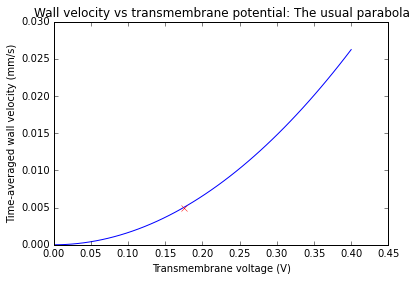

In [439]:
#Now I could plot velocity as a function of e-field for our geometry
varray=np.linspace(0,0.4,50)
wallvels=np.array([avgWallVel(v,lmlp,rplm,2.83,zetaPolymer,plength) for v in varray])
plt.plot(varray,-wallvels)
plt.xlabel('Transmembrane voltage (V)')
plt.ylabel('Time-averaged wall velocity (mm/s)')
plt.hold('true')
plt.plot(0.175,0.005,'rx')#We got 0.005 mm/s in intake video, what would the transmembrane voltage have had to be
#if everything was linear
#it looks like 0.175 V
#what would the zeta potential be if 0.175V was applied-- less than 20 mV so that's linear
#But we are applying 120-130 V from the electrodes.
#Could ion crowding be shorting out the pore a bit, making it hard to develop more than a volt transmembrane?
plt.title('Wall velocity vs transmembrane potential: The usual parabola')
lmlp,rplm,zetaPolymer,plength

In [440]:
#Now want to know pressure drop for this amount of flow. use Hagen-Poiseuille pipe flow equation 
#Equate Janus ICEO pump paper equations 5 and 6  -- but use Jaz's video flow rate measurement for Eq 5
#Then solve equation 6 for delta-P, which is the max pressure.
#Do we get in the 400 Pa range?
n=1e8 #(Number of pores per cm2)
diskrad=.5 #exposed membrane radius in cm
N=np.pi*diskrad**2*n #total number of pores in the membrane
rpore=200e-9 #individual pore radius in meters. result is very sensitive to this.
tubelength=0.2 #Silicone tube length in meters - Total length of silicone tubes leading to and exiting device
tuberadius=0.0005 #Silicone tube radius in meters, about 1mm inner diameter
#ignore the pressure drop in the 1cm wide acrylic thing leading up to the membrane, and the holey support.


def pressuredrop (plength,N,rpore,tubelength,tuberadius):#feed it average velocity in mm/s
    qmax=4e-9/82# intake in cubic meters per second observed by Jaz
    #This is the intake Jaz measured, not sure if there was any pressure drop in the tubes leading to it
    pmax=qmax*8*eta*(plength/(N*np.pi*rpore**4)+ tubelength/(np.pi*tuberadius**4)) #Hagen-Poiseuille flow
    #for a membrane with N pores in parallel, all in series with the silicone tube
    return pmax

pmax=pressuredrop(plength,N,rpore,tubelength,tuberadius)
uwall=4e-9/82/(np.pi*rpore**2)*1000/N#Jaz got about 4 microliters (4x10-9 cubic meters) in 82 s of video
#Wall velocity in mm/s is coming out to be about 0.005
N,pmax,uwall #max pressure in pascals from flow. It is only coming out like 9 Pa. 
#But we measure pressure drops in the high 300 Pa range.
#Could the extra pressure we see be coming from electrolysis bubbles at the metal face?
#If so, wouldn't we see more fluid coming out than going in, at first? Yes the outflow is faster than inflow.
#What would measuring the electric current be able to tell us?

(78539816.33974482, 9.151418503910868, 0.004942496763040869)

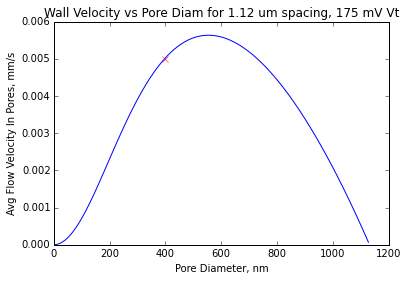

In [441]:
#How about calculating the side wall velocity as a function of PORE DIAMETER
#Keep pore-pore spacing same as in the 400 nm pore system but vary pore radius
#This means keeping rf (the average pore center-center spacing/2) at 566 nm which is what is in the 400nm diameter pores.
#This means take the pore radius from 100 to 550 nm
#or pore diameter from 200 to 1100 nm. any bigger and pores collide!

dp=np.linspace(2e-9,1128e-9,90)#Pore diameter ranges from to 200 nm diameter,to 1100 nm dia
#I like putting it in terms of diameter for plots bc that's how we buy the nanopores

rp=dp/2#pore radius array in meters
rf=566e-9#flange radius in meters

#Keep pore radius/metal depth (rplm) at 0.2 (from the observation that metal goes about 5 radii deep with sputtering)

#This means lmlp will vary bc we get deeper metal in larger pores. lm/lp = 5*rp/plength

uavg=np.array([avgWallVel(Vt,5*r/plength,0.2,rf/r,zetaPolymer,plength) for r in rp])
plt.plot(dp*1e9,-uavg)
plt.hold ('true')
plt.plot(400,0.005,'rx')
plt.xlabel('Pore Diameter, nm')
plt.ylabel('Avg Flow Velocity In Pores, mm/s')
plt.title ('Wall Velocity vs Pore Diam for 1.12 um spacing, 175 mV Vt')

#We see a local max flow rate near 550 nm. This is because at smaller pore sizes,
#the metal doesn't get in as deep during sputtering,
#and at larger pore sizes, each pore "owns" less of the top metal film
#...there's not as strong a charge imbalance when they're all jammed close together.

#of course if you buy 3um pores from SPI they wont be spaced 1.12 microns apart

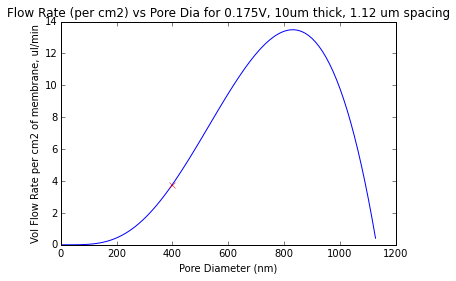

In [442]:
#Volumetric Flow Rate per cm2 vs pore radius
#For a 10 micron thick, 1.12 micron spacing, 17.5 mV Vt, 10^8 pores/cm2 membrane that matches our 0.4 micron results
Q=np.array([n*np.pi*(r*1e3)**2*avgWallVel(Vt,5*r/plength,0.2,rf/r,zetaPolymer,plength) for r in rp]) #In ul/s
plt.plot(dp*1e9,-Q*60) #this curve was scaled to map onto exptl data with one fitting parameter, v=0.175V
plt.xlabel('Pore Diameter (nm)')
plt.ylabel('Vol Flow Rate per cm2 of membrane, ul/min')
plt.hold('true')
plt.plot(400,3.72,'rx')#experimental data for 400 nm pores
#would it match with a 2nd or 3rd data point though?
plt.title('Flow Rate (per cm2) vs Pore Dia for 0.175V, 10um thick, 1.12 um spacing')

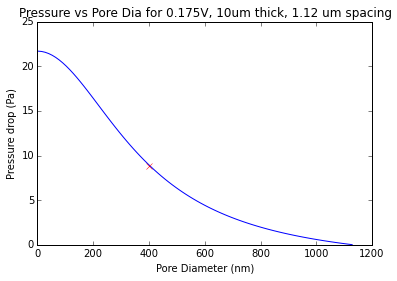

In [443]:
#Pressure vs pore radius with everything else fixed-- probably we won't be able to measure this pressure bc of bubbles
pressurePore=np.array([8.0*eta*q*plength/(np.pi*(r)**4) for r,q in zip(rp,Q/n*1e-9)])
plt.plot(dp*1e9,-pressurePore)
plt.xlabel('Pore Diameter (nm)')
plt.ylabel('Pressure drop (Pa)')
plt.hold('true')
plt.plot(400,8.8,'rx')
plt.title('Pressure vs Pore Dia for 0.175V, 10um thick, 1.12 um spacing')

In [444]:
#These results mean that we quit pumping small pore size where the metal can't reach

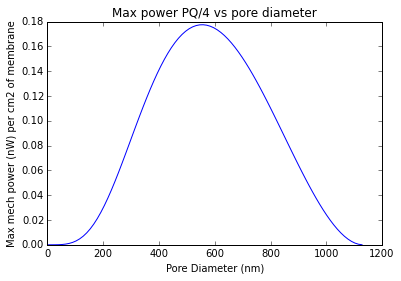

In [445]:
#Max pump power is Pmax/2 * Qmax/2 = PQ/4
#this comes from the pump circuit equation, flow rate= Q = Qmax (1-P/Pmax)
#and power in Watts is P*Q  = P*Qmax (1-P/Pmax)
#take derivative of power with respect to pressure P, set derivative to zero, and max power is developed when P=Pmax/2
#plug in P=Pmax/2 to solve for Q at max power, it's Qmax/2
plt.plot(dp*1e9,pressurePore*Q/4)
plt.xlabel('Pore Diameter (nm)')
plt.ylabel('Max mech power (nW) per cm2 of membrane')
#Max power in Watts (per cm2 of membrane)
plt.title('Max power PQ/4 vs pore diameter')